In [26]:
%matplotlib inline
%load_ext line_profiler
import numpy as np
import pandas as pd
import math
import scipy
import scipy.stats as ss
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.animation as animation
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import rc
from matplotlib.patches import Rectangle
import seaborn.apionly as sns
from IPython.display import HTML
import os, glob, sys
import warnings
warnings.simplefilter('always')

from bokeh.server.server import Server
from bokeh.application import Application
from bokeh.application.handlers.function import FunctionHandler
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models.sources import ColumnDataSource
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from bokeh.layouts import gridplot
from bokeh.models import HoverTool
from bokeh.plotting import figure 
output_notebook()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Loading BokehJS ...

In [27]:
np.seterr(all='raise', divide='ignore', over='raise', under='ignore', invalid='raise')

{'divide': 'ignore', 'invalid': 'raise', 'over': 'raise', 'under': 'ignore'}

#### Load Generated Synthetic Data

In [28]:
data = pd.read_csv('observation.csv')
data = data.drop(['Unnamed: 0'],axis=1)

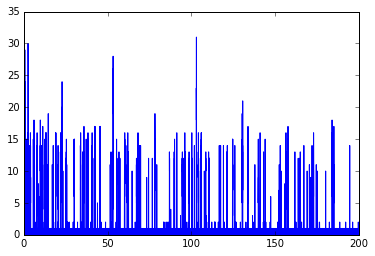

In [29]:
%matplotlib inline
plt.plot(data['0'],data['1'])

N is Number of time levels and is obtained from the length of observations

In [30]:
Wn = np.array(data['1'])
N = len(Wn)  

In [31]:
class FFBS:
    def emission_distribution(self,x,Sn,params,M,ID,Snm):
        # This is needed for the calculation of the Filter
        ind = list(range(M))
        ind.remove(ID)
        self.Ksn = np.where(Sn==1,params['k_sigma2'],0.0) # Ksn[M,N]
        self.Ksn_filter = [0.0,params['k_sigma2'],0.0,0.0,0.0,params['k_sigma2'],0.0,0.0] # Ksn_filter[8]
        #self.rate [8,N]
        r = params['theta']*hyper_param['dt']*(params['rho']+np.dot(params['bm'][0,ind],self.Ksn[ind,:]))
        self.rate = [r+params['theta']*hyper_param['dt']*self.Ksn_filter[i] for i in range(2)]   
        likelihood = [-self.rate[0]+x*np.log(self.rate[0]),-self.rate[1]+x*np.log(self.rate[1])]
        
        d = []
        d.append(likelihood)
        for i in range(6):
            d.append(likelihood[0])         
        
        return np.vstack(d)
    
    # Filter changes for each particle because of the change in the rates. But transition matrix is the same.
    def Filter(self,pi,pi_filter,N,ID,Sn,Snm,Wn,M,params,hyper_param):  
        A = np.zeros([8,N], dtype=np.float64)
        A_star = np.zeros([8], dtype=np.float64)
        # Likelihood or Emission distribution
        F = self.emission_distribution(Wn,Sn,params,M,ID,Snm)      # F[8,N]
        
        p1 = hyper_param['gama']/(hyper_param['gama']+M-1)
        pi0 = np.array([p1,0,0,0,1-p1,0,0,0])   # pi0[8,1] 
#         A_star = pi0*F[:,0]
#         c1 = np.sum(A_star)
#         A[:,0] = A_star[:]/c1  # Array of 8*N where 8 is the number of possible states for the filter 
        
        pi_filter_log = np.where(pi_filter!=0,np.log(pi_filter),0)
        A[:,0] = pi0
        for i in range(1,N):
            sum_ = np.where(pi_filter_log!=0,pi_filter_log+np.log(A[:,i-1]),0)
            sum_final = np.sum(sum_,axis=1)
            MM = -np.maximum.reduce(sum_final)
            sum_ = np.where(sum_!=0,sum_+MM,0)
            d = F[:,i]-MM+np.log(np.sum(np.where(sum_!=0,np.exp(sum_),0),axis=1))
            A_star = np.exp(d)
            c1 = np.sum(A_star)
            A[:,i] = A_star/c1
    
        return A
    
    def sample(self,weight):
        P = np.cumsum(weight)
        return np.searchsorted(P, np.random.uniform())
    
    def _FFBS(self,N,pi,pi_filter,params):
        # States of the system considered for the filter
        Snm = np.column_stack([[1,1,1,1,0,0,0,0],[0,1,2,3,0,1,2,3]]) #Snm[8,2]
        bm = np.zeros([1,M],dtype=int) 
        for ID in range(M):      
            A = self.Filter(pi,pi_filter,N,ID,Sn,Snm,Wn,M,params,hyper_param) # A[8,N]
            # Sanity Check
            if np.sum(A,axis=0).all()==1:
                pass
            else:
                raise Exception('Filter is not working for ID{} with {}'.format(ID,np.sum(A,axis=0)))
             
            ind_N = np.random.choice(8,p=A[:,N-1])  # Get the state at the last time level
            Sn[ID,N-1] = Snm[ind_N,1]
            bm[0,ID] = Snm[ind_N,0]
            AA = A[:4,:] if ind_N<4 else A[4:,:]    # AA[4,N]
            
            for n in range(N-2,-1,-1):
                weight = AA[:,n]*pi[:,Sn[ID,n+1]]
                weight /= np.sum(weight)
                Sn[ID,n] = self.sample(weight)
          
        return bm, Sn

In [32]:
class Metropolis_Hastings:
    def __init__(self,alfa1,alfa2):
        self.alfa1 = alfa1
        self.alfa2 = alfa2
        
    def _proposal(self,x,alfa):
        return np.random.gamma(alfa,scale=x/alfa) 
    
    def sample(self,rho_old,k_sigma2_old):
        rho_prop = self._proposal(rho_old,self.alfa1) 
        k_sigma2_prop = self._proposal(k_sigma2_old,self.alfa2)
        return rho_prop, k_sigma2_prop
    
    def _proposal_pdf(self,x1,x2,alfa):
        return ((2*alfa-1)*(np.log(x1)-np.log(x2))+alfa*(x2/x1-x1/x2))
    
    def _prior(self,x1,x2,alfa,beta):
        return (alfa-1)*(np.log(x2)-np.log(x1))+(x1-x2)/beta
    
    def _likelihood(self,x1,y1,x2,y2,Sn,params,hyper_param,Wn):
        Ksn1 = np.where(Sn==1,y1,0.0)
        rate1 = params['theta']*(x1+np.dot(params['bm'],Ksn1))*hyper_param['dt'] 
        
        Ksn2 = np.where(Sn==1,y2,0.0)
        rate2 = params['theta']*(x2+np.dot(params['bm'],Ksn2))*hyper_param['dt'] 

        return np.sum(Wn*(np.log(rate1)-np.log(rate2))+(rate2-rate1))
    
    def Acceptance_ratio(self,params,hyper_param,rho_prop,k_sigma2_prop,rho_old,k_sigma2_old,Wn):        
        # Calculated the log of Prior_ratio, Proposal_ratio, and Likelihood_ratio
        prior_ratio = (self._prior(rho_old,rho_prop,hyper_param['alfa1_prior'],hyper_param['beta1'])+
                       self._prior(k_sigma2_old,k_sigma2_prop,hyper_param['alfa2_prior'],hyper_param['beta2']))         
        
        proposal_ratio = (self._proposal_pdf(rho_old,rho_prop,self.alfa1)+
                          self._proposal_pdf(k_sigma2_old,k_sigma2_prop,self.alfa2))
        
        likelihood_ratio = self._likelihood(rho_prop,k_sigma2_prop,rho_old,k_sigma2_old,Sn,params,hyper_param,Wn) 
        
        return likelihood_ratio+prior_ratio+proposal_ratio

In [33]:
class Gibbs_sampler:  
    def update_theta(self,alfa,beta,Wn,Ksn,params):
        alfa_new = alfa+np.sum(Wn)
        beta_new = beta+np.sum((params['rho']+np.dot(params['bm'][0,:],Ksn))*hyper_param['dt'])
        
        return np.random.gamma(alfa_new,1./beta_new)
    
    def update_roh_ksigma2(self,params,repeats,accepted):
        MH = Metropolis_Hastings(hyper_param['alfa1_proposal'],hyper_param['alfa2_proposal'])
        rho_old = params['rho']
        k_sigma2_old = params['k_sigma2']
        
        # Step (a)
        rho_prop,k_sigma2_prop = MH.sample(rho_old,k_sigma2_old)
        # Step (b)
        AR = MH.Acceptance_ratio(params,hyper_param,rho_prop,k_sigma2_prop,rho_old,k_sigma2_old,Wn)
        # Step (c)
        v = np.random.exponential(scale=1)
        # Step (d)
        if v>-AR:
            accepted = accepted + 1.0
            return rho_prop, k_sigma2_prop, accepted
        else:
            return rho_old, k_sigma2_old, accepted 
            
    def update_pi(self,Sn,M):
        # total number of transitions for all particles over time 
        # is M*(N-1)
        count = dict({0:{0:0,1:0,2:0,3:0},1:{0:0,1:0,2:0,3:0},
                      2:{0:0,1:0,2:0,3:0},3:{0:0,1:0,2:0,3:0}})
        for j in range(M):
            for i in range(N-1):
                state1 = Sn[j,i]
                if Sn[j,i+1]==0:
                    count[state1][0] += 1
                elif Sn[j,i+1]==1:
                    count[state1][1] += 1
                elif Sn[j,i+1]==2:
                    count[state1][2] += 1
                elif Sn[j,i+1]==3:
                    count[state1][3] += 1
                    
        if count[0][1]>M:
            raise Exception('Wrong transitions are happening')
            
        return count

    def update_weight_State(self,hyper_param,pi,pi_filter,params):
        ffbs = FFBS()
        return ffbs._FFBS(N,pi,pi_filter,params)

In [34]:
def update_pi_filter(pi):
    aa = np.zeros([4,4],dtype=np.float64)
    d1 = np.column_stack([pi,aa])
    d2 = np.column_stack([aa,pi])
    return np.vstack([d1,d2])

In [35]:
def __main__(repeats,M,pi,Sn,Ksn,handle):
    data1 = 'Wn.h5'
    data2 = 'params.h5'
    data3 = 'trajectory.h5'
    
    data = dict({'theta': [],'rho': [],'k_sigma2': [],'B':[], 'ite':[],'E_b':[],'E_ph':[]})

    gibbs = Gibbs_sampler()
    accepted  = 0.0
    p = pd.DataFrame()
    for j in range(repeats):
        print(j)
        start1 =  time.time()
        params['theta'] = gibbs.update_theta(hyper_param['alfa'],hyper_param['beta'],Wn,Ksn,params)
        # Metropolis Hastings
        params['rho'], params['k_sigma2'], accepted = gibbs.update_roh_ksigma2(params,repeats,accepted)
        # Update Transition Probabilities
        count = gibbs.update_pi(Sn,M)

        state = 0 
        pi[0] = np.array(list(np.random.dirichlet((0.7+count[state][0],0.3+count[state][1])))+[0,0])
        state = 1
        pi[1] = np.array([0]+list(np.random.dirichlet((0.25+count[state][1],0.25+count[state][2],0.2+count[state][3]))))
        state = 2 
        pi[2] = np.array([0]+list(np.random.dirichlet((0.4+count[state][1],0.6+count[state][2])))+[0])
        pi[3] = np.array([0,0,0,1])
        
        pi_filter = update_pi_filter(pi)
        p = pd.concat([p,pd.DataFrame(pi)],axis=0)
        
        # Sanity Check
        if all(np.sum(pi,axis=1))==1 and all(np.sum(pi_filter,axis=1))==1:
            pass
        else:
            raise Exception('probabilities do not sum to 1')      
        print(params['theta'],params['rho'],params['k_sigma2'])
        
        # FFBS
        params['bm'], Sn = gibbs.update_weight_State(hyper_param,pi,pi_filter,params)

        # Sanity Check
        if all(Sn[:,0])==0:
            pass
        else:
            raise Exception('The initial state of the particle is not zero')
            
        # Store the Date
        data['theta'].append(params['theta'])
        data['rho'].append(params['rho'])
        data['k_sigma2'].append(params['k_sigma2'])  
        data['E_b'].append(params['theta']*params['rho'])
        data['E_ph'].append(params['theta']*params['k_sigma2'])
        data['B'].append(np.count_nonzero(params['bm']))      
        data['ite'].append(j)
    
        # Timing
        start2 = time.time()
        print(start2-start1,np.count_nonzero(params['bm']),accepted)

        # Save the output
        ## MCMC Chain Parameters
        df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in data.items()]))
        params_data = pd.HDFStore(data2)
        params_data['df{}'.format(j)] = df.loc[j]
        params_data.close()
        ## Emission Distribution
        Ksn = np.where(Sn==1,params['k_sigma2'],0.0)
        estimated_emission = params['theta']*(params['rho']+np.dot(params['bm'],Ksn))*hyper_param['dt']
        estimated_emission_final = pd.DataFrame(dict({'ite':range(N),'est':estimated_emission.reshape(N,)}))
        
        if j%500==0:
            emission_data = pd.HDFStore(data1)
            emission_data['df{}'.format(j)] = pd.DataFrame(estimated_emission)
            emission_data.close()
            ## Trajectory of data
            trajectory_data = pd.HDFStore(data3)
            trajectory_data['df{}'.format(j)] = pd.DataFrame(Sn)
            trajectory_data.close()
            
        # Some postprocessing
#         new_data = dict({'E_b': [params['theta']*params['rho']],'E_ph': [params['theta']*params['k_sigma2']],
#                          'B':[np.count_nonzero(params['bm'])],'ite':[j]})
#         plot_traces(estimated_emission_final,new_data,handle)
    
    # Calculate Acceptance Rate
    Acceptance_rate = accepted/repeats
    print ("Acceptance rate = " + str(Acceptance_rate*100))
    
    return data, Acceptance_rate, p

#### Hyper-parameters:
dt is the exposure time, alfa & beta are hyper-parameters of Theta, alfa1 & beta1 are hyper-parameters of Rho,
alfa2 & beta2 are hyper-parameters of K_sigma2

In [36]:
repeats = 20000

In [37]:
hyper_param = {'alfa':1.0,'beta':1.0,'alfa1_proposal':1500,'beta1':1.0,'alfa1_prior':1.0,'alfa2_prior':1.0,
               'alfa2_proposal':1500,'beta2':1.0,'N_particles':75,'gama':1.0,'dt':0.01*.95} 

In [38]:
M = hyper_param['N_particles']

## Parameters to be calculated by Gibbs Sampler 

In [39]:
# data1 = 'Wn.h5'
# data2 = 'params.h5'
# params_data = pd.HDFStore(data2)
# params = params_data['df{}'.format(15999)] 
# params = dict(params)

In [40]:
# params_data.close()

In [41]:
params = {'theta':1e+3,
          'rho':0.01,
          'k_sigma2':1,
          'bm':np.ones((1,M),dtype=int)}  # bm[1,M]

#### Note: 
The weights for the transition probability distribution are our hyper-parameters and we assume them.

In [42]:
pi0 = np.array(list(np.random.dirichlet((0.7,0.3)))+[0,0])
pi1 = np.array([0]+list(np.random.dirichlet((0.55,0.25,0.2))))
pi2 = np.array([0]+list(np.random.dirichlet((0.4,0.6)))+[0])
pi3 = np.array([0,0,0,1])

In [43]:
pi = np.stack((pi0,pi1,pi2,pi3),axis=0)

In [44]:
pi

array([[9.98434714e-01, 1.56528637e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.61591145e-01, 9.39398441e-05, 3.83149149e-02],
       [0.00000000e+00, 6.42445062e-01, 3.57554938e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

#### Note: 
We know that the initial states of all particles is known and they are Inactive at the initial time level 

In [45]:
# data3 = 'trajectory.h5'
# trajectory_data = pd.HDFStore(data3)

In [46]:
Sn = np.zeros([M,N],dtype=np.int)
Sn[:,0] = 0

In [47]:
# Note: Always double check to make sure wrong transitions are not happening, like more than one transition   
# from state zero to state one and from state one to state zero.
for i in range(M):
    for j in range(1,N):
        Sn[i,j] = np.random.choice(4,p=pi[Sn[i,j-1]])  #Sn[M,N] 
# Sn = pd.DataFrame(Sn)  # This is not efficient from computation point of view

In [48]:
Ksn = np.where(Sn==1,params['k_sigma2'],0.0)   # Ksn[M,N]

In [49]:
def plot_traces(estimated_emission_final,new_data,handle):
    source.stream(new_data)
    source1.stream(estimated_emission_final)
#     doc.add_periodic_callback(__main__)
    push_notebook(handle=handle)

In [50]:
import time
from line_profiler import LineProfiler
if __name__ == '__main__':
    if os.path.isfile('Wn.h5'):
        os.remove('Wn.h5')
        os.remove('params.h5')
        os.remove('trajectory.h5')
        
    output_notebook()
    source = ColumnDataSource({'E_b':[],'E_ph':[],'B':[],'ite':[]})
    
    s1 = figure(width=250, plot_height=250, title=None)
    s1.scatter(x='ite', y='B', color="navy", alpha=0.5, source=source)

    s2 = figure(width=250, height=250, title=None)
    s2.scatter(x='ite', y='E_b', color="firebrick", alpha=0.5, source=source)

    s3 = figure(width=350, height=250, title=None)
    s3.scatter(x='ite', y='E_ph', color="olive", alpha=0.5, source=source)
    
    source1 = ColumnDataSource(pd.DataFrame(columns=['ite','est']))
    s4 = figure(width=350, height=250, title=None)
    s4.scatter(x='ite', y='est', color="black", alpha=0.5, source=source1)
    s4.scatter(range(N), Wn, color="blue", alpha=0.5)
    
    pl = gridplot([[s1,s2,s3],[s4]], toolbar_location=None)
    handle = show(pl, notebook_handle=True, new='window', notebook_url='localhost:8888')
    
    out = __main__(repeats,M,pi,Sn,Ksn,handle) 
    # Use line-profiler for optimization
#     lp = LineProfiler()
#     lp.add_function(FFBS._FFBS)
#     lp_wrapper = lp(__main__)
#     lp_wrapper(repeats,M,pi,Sn,Ksn,pl)
#     lp.print_stats(), format='pdf'
#------------------------------------------------------
#     %lprun -f __main__  __main__(repeats,M,pi,Sn,Ksn) 

Loading BokehJS ...

0
860.3036796534984 0.01 1
56.253132581710815 2 0.0
1
5603.296422217283 0.010065512902247161 0.9978542010797682
56.88733768463135 1 1.0
2
5581.254585314613 0.010269256574877313 1.0083876698023593
55.02545738220215 4 2.0
3
5549.0916141595735 0.010333460339327203 1.0048848330870104
56.23042273521423 1 3.0
4
5536.279348924038 0.010333460339327203 1.0048848330870104
55.952786684036255 0 3.0
5
5512.502403836574 0.010419051284141946 0.9838602205688335
56.16578030586243 0 4.0
6
5403.388001858649 0.010419051284141946 0.9838602205688335
56.174519777297974 2 4.0
7
5498.13640365037 0.010419051284141946 0.9838602205688335
55.95644402503967 0 4.0
8
5426.9090604567145 0.010419051284141946 0.9838602205688335
57.843355894088745 1 4.0
9
5451.187784797032 0.010769190375236456 0.9925846483359215
57.77847671508789 1 5.0
10
5377.0933893813635 0.010769190375236456 0.9925846483359215
57.11830282211304 1 5.0
11
5375.197500597171 0.010769190375236456 0.9925846483359215
57.369251012802124 0 5.0
12
5402.78452626

3399.9739784632493 0.020324966494770797 0.8672802036697097
55.549484968185425 1 49.0
97
3355.3939767433494 0.021282122012135883 0.8810223534345529
55.645039558410645 0 50.0
98
3220.707199991153 0.021282122012135883 0.8810223534345529
55.02669382095337 0 50.0
99
3228.944516441346 0.021282122012135883 0.8810223534345529
55.743486642837524 1 50.0
100
3205.552869343564 0.021282122012135883 0.8810223534345529
55.67985773086548 2 50.0
101
3227.861875295624 0.02175510635266724 0.8719699414265887
54.93559956550598 1 51.0
102
3179.9721680762086 0.02175510635266724 0.8719699414265887
55.60969257354736 3 51.0
103
3145.7117947748757 0.021970896121932055 0.8833300426507631
55.30817675590515 1 52.0
104
3184.2432789266736 0.021970896121932055 0.8833300426507631
55.446428298950195 1 52.0
105
3135.3747022428106 0.02205208206875129 0.8725969254496573
55.94331383705139 2 53.0
106
3096.357895127954 0.02275675833779882 0.8810931076669503
55.95103430747986 3 54.0
107
3081.266519656027 0.02275675833779882 0.

56.06061816215515 0 96.0
191
1281.6103973609283 0.06148192566028484 0.9659286656728707
55.12626385688782 1 96.0
192
1289.521418154425 0.0623119545027179 0.9537809868789685
55.632134199142456 1 97.0
193
1286.1388780749453 0.0623119545027179 0.9537809868789685
55.42667579650879 1 97.0
194
1270.9425981950585 0.0633828074791003 0.9426168890649171
55.35247540473938 1 98.0
195
1253.3457288955217 0.0633828074791003 0.9426168890649171
55.979098081588745 1 98.0
196
1246.8327777117668 0.06421594845677357 0.9201643967535428
54.74055743217468 0 99.0
197
1238.282119506955 0.06421594845677357 0.9201643967535428
55.22124171257019 1 99.0
198
1243.6804017379486 0.06421594845677357 0.9201643967535428
55.23236155509949 2 99.0
199
1230.8018915970983 0.06421594845677357 0.9201643967535428
55.040647983551025 0 99.0
200
1252.0502052829977 0.0649490866993184 0.8924641393111545
56.044657468795776 1 100.0
201
1240.095518976901 0.06558459755920713 0.890769277801621
55.42022633552551 1 101.0
202
1205.109063896524

500.7699126913291 0.17119760892942423 0.6847740525247126
55.24531650543213 0 149.0
286
489.98134759008525 0.1710660214253875 0.6908618564755448
55.30516242980957 0 150.0
287
486.37738199401844 0.1710660214253875 0.6908618564755448
54.88015127182007 0 150.0
288
490.1920844389509 0.1710660214253875 0.6908618564755448
55.51925015449524 0 150.0
289
485.52357240522934 0.17222040438550743 0.6967339562174215
55.11539101600647 1 151.0
290
486.26261342089396 0.17606537670396477 0.6702272083528168
55.48567843437195 3 152.0
291
475.19573228830836 0.17606537670396477 0.6702272083528168
55.43642783164978 0 152.0
292
477.04891533548493 0.17606537670396477 0.6702272083528168
55.346778869628906 0 152.0
293
473.69516810881083 0.176590499425315 0.6637614310887527
55.8930344581604 4 153.0
294
469.8315058983935 0.176590499425315 0.6637614310887527
55.32636833190918 2 153.0
295
470.2169859947641 0.176590499425315 0.6637614310887527
55.27825379371643 0 153.0
296
473.8287451271233 0.176590499425315 0.6637614

55.28176736831665 0 192.0
380
260.8040532439027 0.32429635547186353 0.6165263850522609
55.39207720756531 1 192.0
381
258.98836298998947 0.3297077762672102 0.5989554830968339
54.98843955993652 3 193.0
382
256.7166532228765 0.3387745046910703 0.6115068296349017
55.20933699607849 0 194.0
383
245.49481433696678 0.3387745046910703 0.6115068296349017
55.24996829032898 2 194.0
384
250.42957038461796 0.3387745046910703 0.6115068296349017
55.29229474067688 0 194.0
385
248.8490265123292 0.3387745046910703 0.6115068296349017
55.46648120880127 1 194.0
386
249.66925618691138 0.3403465340617234 0.5937206810587697
55.331719636917114 2 195.0
387
251.599382884682 0.34107042677206284 0.614084560941367
55.17452549934387 2 196.0
388
250.0951007343904 0.34107042677206284 0.614084560941367
55.35192346572876 2 196.0
389
246.1489695023786 0.34107042677206284 0.614084560941367
55.78404092788696 2 196.0
390
242.26925352870683 0.35201576986994465 0.6394703367365187
55.64447236061096 1 197.0
391
241.1718317159205

165.38874705686317 0.51868722106399 0.580016197129092
54.87276554107666 1 233.0
475
163.41328778068038 0.5238858136765637 0.5888678232581048
55.28766369819641 1 234.0
476
164.74104075411228 0.5238858136765637 0.5888678232581048
54.91720247268677 2 234.0
477
161.74965586272742 0.5265984676962522 0.5967500001692363
55.44343948364258 1 235.0
478
163.3491972921662 0.5265984676962522 0.5967500001692363
55.518120527267456 2 235.0
479
160.887598244557 0.5265984676962522 0.5967500001692363
55.062339305877686 2 235.0
480
161.65644140560158 0.5265984676962522 0.5967500001692363
54.853147983551025 1 235.0
481
161.58431777382145 0.5326532029296186 0.5987332343397471
55.611392974853516 1 236.0
482
158.83557733713116 0.5326532029296186 0.5987332343397471
55.0141224861145 1 236.0
483
161.10808353098082 0.5326532029296186 0.5987332343397471
55.71188735961914 2 236.0
484
159.89731859298814 0.5326532029296186 0.5987332343397471
55.03607225418091 1 236.0
485
159.43088131467883 0.5326532029296186 0.598733

56.09656262397766 0 277.0
569
113.25518867637533 0.7531168874152583 0.6595329599202467
56.37272620201111 0 277.0
570
111.81191283741082 0.7531168874152583 0.6595329599202467
56.43068981170654 1 277.0
571
113.95732735758737 0.7531168874152583 0.6595329599202467
55.46892285346985 0 277.0
572
114.89046422618453 0.7531168874152583 0.6595329599202467
55.78540277481079 1 277.0
573
114.0975040321736 0.7531168874152583 0.6595329599202467
55.43040680885315 0 277.0
574
112.85618367402175 0.7531168874152583 0.6595329599202467
55.541542768478394 1 277.0
575
113.61232713006062 0.7516107657498146 0.6374131526742892
55.49122142791748 2 278.0
576
112.87380952235083 0.7516107657498146 0.6374131526742892
55.50357794761658 2 278.0
577
113.6066450948713 0.7516107657498146 0.6374131526742892
55.191681146621704 0 278.0
578
112.40394731483364 0.7674374499466845 0.6552352938715096
55.21336889266968 1 279.0
579
112.28608894078442 0.7672270547792336 0.6187523303020087
55.03788185119629 1 280.0
580
110.371437086

55.09293079376221 1 316.0
664
96.67157070053007 0.8799310692028662 0.6360276482522156
55.18012261390686 0 317.0
665
96.74328354002766 0.8815548390481371 0.6189577900599719
55.14535856246948 0 318.0
666
96.69611406853612 0.8884456111110725 0.6221320585360417
55.96658706665039 0 319.0
667
95.74392556324213 0.8884456111110725 0.6221320585360417
55.53551411628723 3 319.0
668
95.43363605284887 0.8857025112658811 0.5979994977718006
55.72475838661194 3 320.0
669
96.25884955751378 0.8834085123301152 0.5968580534007031
55.680171728134155 1 321.0
670
97.23766770238059 0.8834085123301152 0.5968580534007031
55.91770076751709 2 321.0
671
96.53318298745654 0.896716805642581 0.5688582369873926
55.89545297622681 4 322.0
672
96.13926196089866 0.8976266058947929 0.5781384718350977
55.958282232284546 1 323.0
673
94.76263445538851 0.8976266058947929 0.5781384718350977
55.55137276649475 3 323.0
674
92.62218059130228 0.9079598335783468 0.5745786849635057
56.11248826980591 4 324.0
675
94.89009548923781 0.896

56.0327262878418 1 356.0
760
82.33447967007608 1.0337381866677045 0.6644911388644041
56.80152678489685 1 356.0
761
81.6123023061613 1.0337381866677045 0.6644911388644041
55.67235350608826 2 356.0
762
82.47768961808202 1.0337381866677045 0.6644911388644041
55.235936880111694 0 356.0
763
83.3092798791991 1.0337381866677045 0.6644911388644041
54.778661251068115 2 356.0
764
81.64397188721061 1.0633507095606058 0.6756402309943829
55.74490761756897 1 357.0
765
80.676534957477 1.0628101533291059 0.6748214516479207
55.231531381607056 1 358.0
766
79.63531240409237 1.0788818496481187 0.708510143078482
55.345654249191284 1 359.0
767
78.58076532995484 1.0788818496481187 0.708510143078482
56.3243625164032 2 359.0
768
78.4804331155896 1.1072768715467118 0.7166277051213608
55.37336015701294 0 360.0
769
76.920085535029 1.1072768715467118 0.7166277051213608
55.74811053276062 1 360.0
770
76.67053700265579 1.1307585515419818 0.7471069115518368
56.00112342834473 0 361.0
771
75.29901154166058 1.13075855154

55.58566403388977 2 392.0
856
58.349830588979124 1.4534712164572865 0.7504929598416684
55.63795876502991 1 392.0
857
59.04814641628596 1.4534712164572865 0.7504929598416684
55.659106492996216 2 392.0
858
59.46287192430848 1.4285130100446477 0.7620502632171979
55.43307948112488 2 393.0
859
59.91779882452919 1.4285130100446477 0.7620502632171979
56.125044107437134 0 393.0
860
59.551333708785904 1.4285130100446477 0.7620502632171979
55.73383975028992 0 393.0
861
59.7153489661772 1.4285130100446477 0.7620502632171979
55.762662410736084 2 393.0
862
59.702386105830215 1.4285130100446477 0.7620502632171979
55.6279993057251 1 393.0
863
59.69789967587078 1.4491644617796988 0.771792371301542
56.22300958633423 1 394.0
864
59.40889947084368 1.4297270561655124 0.7749940989554104
55.05923557281494 1 395.0
865
59.92247026714296 1.4297270561655124 0.7749940989554104
54.69793152809143 0 395.0
866
59.504399331319384 1.4259229538565217 0.753622776766124
54.70347332954407 1 396.0
867
59.64916085401733 1.4

55.65311646461487 1 419.0
951
59.143975000130425 1.4436393905299838 0.6610316584451887
55.85308909416199 2 419.0
952
60.31654651611578 1.381229875375864 0.6353236053196161
55.418697357177734 2 420.0
953
61.12744161353561 1.4100630932505178 0.6190041544092517
56.17687702178955 1 421.0
954
60.97275241094816 1.4100630932505178 0.6190041544092517
55.69975399971008 1 421.0
955
61.01399689457363 1.4100630932505178 0.6190041544092517
55.325233936309814 0 421.0
956
60.47865700531044 1.4203691042985795 0.5796983719914893
55.503039836883545 1 422.0
957
60.60285959491919 1.4203691042985795 0.5796983719914893
54.93097424507141 1 422.0
958
60.96997444777965 1.4203691042985795 0.5796983719914893
55.3442599773407 2 422.0
959
60.000271340719124 1.4203691042985795 0.5796983719914893
55.635517597198486 1 422.0
960
59.79565221330345 1.4487940454656432 0.5678082878652192
55.83360171318054 3 423.0
961
59.07230774835052 1.4487940454656432 0.5678082878652192
56.66787934303284 1 423.0
962
59.343602335621135 1

53.96956901707216 1.5767722784537528 0.516258125947755
55.95986557006836 2 445.0
1046
54.58031581768451 1.5767722784537528 0.516258125947755
55.73938822746277 1 445.0
1047
54.52191596943141 1.5767722784537528 0.516258125947755
55.76150417327881 1 445.0
1048
53.818091341650565 1.582094891567237 0.5064980429388454
55.20518469810486 1 446.0
1049
54.109177858264424 1.582094891567237 0.5064980429388454
55.73999524116516 1 446.0
1050
53.945388777805334 1.582094891567237 0.5064980429388454
56.30341696739197 1 446.0
1051
53.47764369934566 1.582094891567237 0.5064980429388454
55.495285987854004 0 446.0
1052
53.98036341811547 1.5724094726418625 0.49208618841835855
55.22161269187927 1 447.0
1053
53.71472549097925 1.5724094726418625 0.49208618841835855
55.56626296043396 2 447.0
1054
54.072452437078454 1.5724094726418625 0.49208618841835855
56.401692390441895 3 447.0
1055
54.41993222476968 1.590137087439611 0.47093217133570126
55.8853223323822 2 448.0
1056
54.86691423683714 1.5422651591107503 0.477

53.22767244092512 1.6039286744430648 0.4177697116922008
55.71170711517334 1 475.0
1140
52.563710669805936 1.6039286744430648 0.4177697116922008
56.04354643821716 0 475.0
1141
53.46000952964824 1.6039286744430648 0.4177697116922008
55.93468260765076 1 475.0
1142
53.11358619057174 1.6039286744430648 0.4177697116922008
56.09668326377869 3 475.0
1143
53.59578355263999 1.6039286744430648 0.4177697116922008
56.07010531425476 1 475.0
1144
53.57327825953618 1.6039286744430648 0.4177697116922008
55.543288469314575 1 475.0
1145
53.49141845047451 1.6039286744430648 0.4177697116922008
55.56337928771973 0 475.0
1146
53.55604871635296 1.6039286744430648 0.4177697116922008
55.657049894332886 1 475.0
1147
52.64540983205474 1.6039286744430648 0.4177697116922008
55.942970752716064 0 475.0
1148
53.357932275249944 1.6039286744430648 0.4177697116922008
55.5995569229126 1 475.0
1149
53.096138876584675 1.6039286744430648 0.4177697116922008
55.39390850067139 0 475.0
1150
52.917981035208186 1.6039286744430648 

56.330894470214844 1 499.0
1233
50.25100013233309 1.7004454938967621 0.39029964296118624
55.68188834190369 1 499.0
1234
50.75040579550151 1.7089022885852583 0.39099709148554057
55.55333423614502 2 500.0
1235
50.023135051195986 1.7089022885852583 0.39099709148554057
55.09316420555115 2 500.0
1236
50.21721343259768 1.7089022885852583 0.39099709148554057
55.815786361694336 2 500.0
1237
50.23264060193953 1.7089022885852583 0.39099709148554057
56.13427734375 0 500.0
1238
49.80159808426273 1.7019944528100588 0.38131224520543766
55.4565544128418 0 501.0
1239
50.04540202916064 1.7016938011647436 0.3834534239209561
55.036986351013184 0 502.0
1240
50.70783296380004 1.7016938011647436 0.3834534239209561
55.780643701553345 4 502.0
1241
50.54369837354679 1.7016938011647436 0.3834534239209561
56.024293661117554 2 502.0
1242
50.40751025132546 1.700773145718117 0.37974116631731203


KeyboardInterrupt: 

In [ ]:
data1 = 'Wn.h5'
emission_data = pd.HDFStore(data1)
fig = plt.figure(figsize=(4,4)) 
    
plt.style.use('ggplot')
sns.set_style('ticks')
plt.rcParams['font.size'] = 12
for i in range(1000,16000,300):
    plt.plot(range(N),emission_data['df{}'.format(i)].iloc[0]) 
plt.scatter(range(N), Wn, color="blue", alpha=0.5)
plt.xlim([0,20000])
# plt.ylim([0,3000])
# plt.ylabel(ylabel)
# plt.xlabel(xlabel)
plt.tight_layout()
sns.despine(offset=10)
fig.savefig('Emission_distribution.pdf')

In [ ]:
df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in out[0].items()]))

In [ ]:
sns.jointplot(x=df['ite'],y=df['B'], kind='scatter',color='g',s =20,linewidth=2)

In [ ]:
sns_plot = sns.jointplot(x=df['ite'],y=df['E_b'], kind='scatter',color='g',s =20,linewidth=2)
sns.set(style="darkgrid", color_codes=False)
sns_plot.savefig('Emission_background.pdf')

In [ ]:
sns_plot = sns.jointplot(x=df['ite'],y=df['E_ph'], kind='scatter',color='g',s =20,linewidth=2)
sns_plot.savefig('Photon_Emission.pdf')

In [ ]:
n, bins, patches = plt.hist(out[0]['E_b'], 50, facecolor='blue')
plt.axvline(10, color='r')

In [ ]:
n, bins, patches = plt.hist(out[0]['E_ph'], 50, facecolor='blue')
plt.axvline(1e+3, color='r')

In [ ]:
step = 0.01
partitions = [i*step for i in range(round(200./step))]
t = partitions

In [ ]:
plt.step(x=t[:-1],y=Sn[0,:])

In [ ]:
out1 = out[2] 
pi_true = np.array([[9.95012479e-01, 4.72285706e-03, 2.40596046e-04, 2.40677016e-05],
                    [0.00000000e+00, 8.95880600e-01, 9.46496180e-02, 9.46978182e-03],
                    [0.00000000e+00, 9.46496180e-04, 9.99048684e-01, 4.82001787e-06],
                    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
d = dict([(index,0) for index,v in np.ndenumerate(pi)])
for index, x in np.ndenumerate(pi):
    i = index[0]
    j = index[1]
    d[index] = list(out1.iloc[i::4,j])
    
def plot_hist(dic, pi_true):
    fig = plt.figure(figsize=(16,16)) 
    plt.style.use('ggplot')
    sns.set_style('ticks')
    plt.rcParams['font.size'] = 12

    nn = 1
    for i, x in np.ndenumerate(pi_true):
        ax = fig.add_subplot(4,4,nn)
        n, bins, patches = plt.hist(dic[i], 10, facecolor='blue')
        plt.axvline(pi_true[i], color='r')
#         ax.set_title(r'$particle-ID: {}$'.format(str(i)))
#         ax.legend().set_visible(False)
        sns.despine(offset=12,ax=ax,trim=True)
        nn = nn+1

    # plt.subplots_adjust(top=0.92,bottom=0.08,left=0.1,right=0.95,wspace=0.6,hspace=0.6)
    plt.tight_layout()
    plt.show() 
    fig.savefig('Probability_distribution.pdf')
    return None

In [ ]:
plot_hist(d, pi_true)